In [2]:
!nvidia-smi

Tue Oct 22 15:27:05 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:01:00.0  On |                  Off |
|  0%   40C    P0             54W /  450W |    1348MiB /  24564MiB |     18%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
!conda info --envs

# conda environments:
#
base                     /home/dickoah/miniconda3
mea_genai                /home/dickoah/miniconda3/envs/mea_genai
nfinite_genai         *  /home/dickoah/miniconda3/envs/nfinite_genai



In [5]:
import torch
from blora_utils import BLOCKS, filter_lora, scale_lora
import matplotlib.pyplot as plt
import cv2

from diffusers import (
    ControlNetModel, 
    DDIMScheduler,
    AutoencoderKL, 
    AutoPipelineForText2Image, 
    AutoPipelineForImage2Image,
    EulerAncestralDiscreteScheduler, 
    TCDScheduler
)
from diffusers.utils import load_image, make_image_grid

import numpy as np

import matplotlib.pyplot as plt

from PIL import Image

import torch


/home/dickoah/miniconda3/envs/nfinite_genai/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-22 15:27:28.244531: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-22 15:27:28.256380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 15:27:28.263569: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10

### Load Image

In [6]:
def apply_mask(image, mask):
    assert(image.shape[0:2]==mask.shape[0:2])
    # canny image
    alpha = mask / 255.0
    # Apply the mask
    image_on_mask = (alpha * image).astype(np.uint8)    
    return image_on_mask

def canny_edge_detection(img, low_threshold=50, high_threshold=200, apertureSize=3, L2gradient=True):
    # Apply Canny edge detection
    image_canny = cv2.Canny(img, low_threshold, high_threshold, apertureSize=apertureSize, L2gradient=L2gradient)
    # Convert the single-channel image to a three-channel image by stacking
    image_canny = np.stack((image_canny,)*3, axis=-1)
    return image_canny

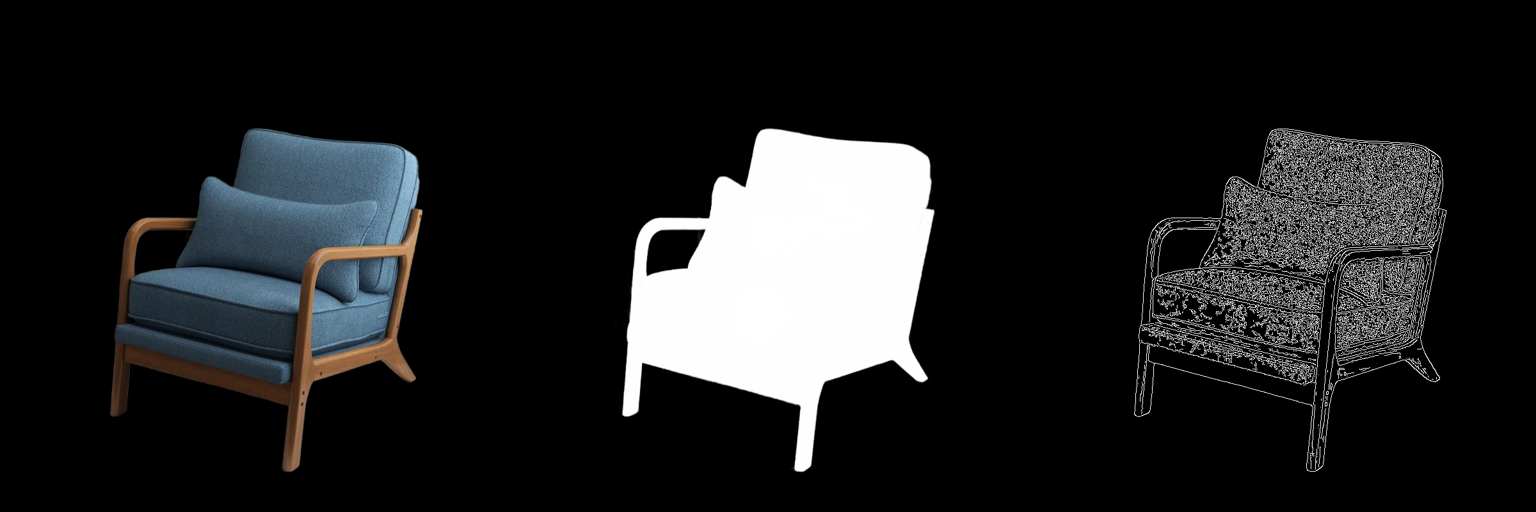

In [7]:
# loading and repositionong of image and mask #src/mea_genai/img/
image_input = load_image("img/image_6.png")
mask_image = load_image("img/image_6_mask.png") 

image_input_array = np.array(image_input)
mask_image_array = np.array(mask_image)

# Apply the mask
input_image_on_mask = apply_mask(image_input_array, mask_image_array)
image_canny = Image.fromarray(canny_edge_detection(input_image_on_mask, low_threshold=25, high_threshold=65, apertureSize=3, L2gradient=False))

# Load your images using load_image
images = [
    image_input,
    mask_image,
    image_canny
]
make_image_grid(images, rows=1, cols=len(images), resize=512)

### Handling of the generation the content

In [8]:
def plot_images(images, titles=None, figsize=(15, 5)):
    fig, axes = plt.subplots(1, len(images), figsize=figsize)

    for i, img in enumerate(images):
        axes[i].imshow(img)
        if titles:
            axes[i].set_title(titles[i])
        axes[i].axis('off')

    plt.show()

def load_b_lora_to_unet(pipe, content_lora_model_id: str = '', style_lora_model_id: str = '', content_alpha: float = 1.,
                        style_alpha: float = 1.) -> None:
    try:
        # Get Content B-LoRA SD
        if content_lora_model_id:
            content_B_LoRA_sd, _ = pipe.lora_state_dict(content_lora_model_id)
            content_B_LoRA = filter_lora(content_B_LoRA_sd, BLOCKS['content'])
            content_B_LoRA = scale_lora(content_B_LoRA, content_alpha)
        else:
            content_B_LoRA = {}

        # Get Style B-LoRA SD
        if style_lora_model_id:
            style_B_LoRA_sd, _ = pipe.lora_state_dict(style_lora_model_id)
            style_B_LoRA = filter_lora(style_B_LoRA_sd, BLOCKS['style'])
            style_B_LoRA = scale_lora(style_B_LoRA, style_alpha)
        else:
            style_B_LoRA = {}

        # Merge B-LoRAs SD
        res_lora = {**content_B_LoRA, **style_B_LoRA}

        # Load
        pipe.load_lora_into_unet(res_lora, None, pipe.unet)
    except Exception as e:
        raise type(e)(f'failed to load_b_lora_to_unet, due to: {e}')

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print("device:", device)

model_id_or_path = "SG161222/RealVisXL_V5.0_Lightning" #stabilityai/stable-diffusion-xl-base-1.0
vae_id_or_path = "madebyollin/sdxl-vae-fp16-fix"

controlnet_canny = ControlNetModel.from_pretrained("xinsir/controlnet-canny-sdxl-1.0", weight_name="diffusion_pytorch_model_V2.safetensors", torch_dtype=torch.float16)

vae = AutoencoderKL.from_pretrained(vae_id_or_path, torch_dtype=torch.float16)

pipe_tex2img = AutoPipelineForText2Image.from_pretrained(model_id_or_path,
                                                         controlnet=controlnet_canny,
                                                         vae=vae,
                                                         torch_dtype=torch.float16,
                                                       )              

# Setting up of others parameters
pipe_tex2img.enable_xformers_memory_efficient_attention()
pipe_tex2img = pipe_tex2img.to(device)

# Update of the scheduler
pipe_tex2img.scheduler = TCDScheduler.from_config(pipe_tex2img.scheduler.config)

device: cuda


Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


In [13]:
content_B_LoRA_path = ""
style_B_LoRA_path = "data/b-lora/Wayfair_img11_pinkflowers/pytorch_lora_weights.safetensors"
content_alpha, style_alpha = 1, 1.1
lora_trigger_word = "[wim11]"

In [14]:
load_b_lora_to_unet(pipe_tex2img, content_B_LoRA_path, style_B_LoRA_path, content_alpha, style_alpha)

In [18]:
seed = torch.randint(0, 1000000, (1,)).item()
generator = torch.Generator(device=device).manual_seed(seed)
print(f"seed: {seed}")

# prompt instanciation
prompt = f'The image shows a chair in a living room in style {lora_trigger_word} with a very large rug on the floor, windows, a cupboard with books and a photo frame on top, a window with a curtain, and a wall in the background, plant in pot, painting on wall, stright-lines.'
print("prompt: ", prompt)
controlnet_conditioning_scale=0.6
images_output = pipe_tex2img(prompt=prompt, 
                             image=image_canny, 
                             controlnet_conditioning_scale=controlnet_conditioning_scale,
                             num_inference_steps=15,
                             num_images_per_prompt=2,
                             guidance_scale=1.7,
                             generator=generator).images

make_image_grid(images_output, rows=1, cols=2, resize=512)

seed: 786689
prompt:  The image shows a chair in a living room in style [wim11] with a very large rug on the floor, windows, a cupboard with books and a photo frame on top, a window with a curtain, and a wall in the background, plant in pot, painting on wall, stright-lines.


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 626.00 MiB. GPU 0 has a total capacity of 23.54 GiB of which 634.56 MiB is free. Process 64040 has 642.70 MiB memory in use. Including non-PyTorch memory, this process has 21.62 GiB memory in use. Of the allocated memory 19.74 GiB is allocated by PyTorch, and 1.42 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [16]:
index = 1
image_output = images_output[index]
plt.imsave(f'ai_image_sdxl_lora_w_caption_seed_{seed}_{index}_blora_{lora_trigger_word.replace("[", "").replace("]", "").replace("wim", "")}.png', np.array(image_output).astype(np.uint8))